# StatQuest SVM

## Credit Card default risk

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import scale
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.decomposition import PCA

In [10]:
df = pd.read_csv("default of credit card clients.csv", header=1)

In [12]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default payment next month
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [13]:
df.rename({'default payment next month' : 'default'}, axis = 'columns', inplace=True)
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000,2,2,1,24,2,2,-1,-1,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,-1,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,-1,0,-1,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


ID columns is randomly assigned, making in uninformative, so we can drop it.

In [14]:
df.drop('ID', axis = 1, inplace=True)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
1,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


## 1. Missing data

In [15]:
df.dtypes

LIMIT_BAL    int64
SEX          int64
EDUCATION    int64
MARRIAGE     int64
AGE          int64
PAY_0        int64
PAY_2        int64
PAY_3        int64
PAY_4        int64
PAY_5        int64
PAY_6        int64
BILL_AMT1    int64
BILL_AMT2    int64
BILL_AMT3    int64
BILL_AMT4    int64
BILL_AMT5    int64
BILL_AMT6    int64
PAY_AMT1     int64
PAY_AMT2     int64
PAY_AMT3     int64
PAY_AMT4     int64
PAY_AMT5     int64
PAY_AMT6     int64
default      int64
dtype: object

In [16]:
df['SEX'].unique()

array([2, 1], dtype=int64)

In [17]:
df['EDUCATION'].unique()

array([2, 1, 3, 5, 4, 6, 0], dtype=int64)

0, 5 and 6 are not in the original data description :(

In [18]:
df['MARRIAGE'].unique()

array([1, 2, 3, 0], dtype=int64)

0 is not in the original data description either :(

In [20]:
len(df.loc[(df['EDUCATION'] == 0) | (df['MARRIAGE'] == 0)])

68

In [21]:
len(df)

30000

So 68 rows out of 30,000 have missing values. That's less than 1% of the whole dataset. That would still be more than enough data we need for Support Vector Machine. We will drop the rows with missing data. 

In [23]:
df_no_missing = df.loc[(df['EDUCATION'] != 0) & (df['MARRIAGE'] != 0)]

In [24]:
df_no_missing.shape

(29932, 24)

## 2. Downsample the data

SVM can take a long time to optimise with cross validations, so we'll downsample both categories (**default** and **not default**) to 1,000 samples each.

In [25]:
df_no_default = df_no_missing[df_no_missing['default'] == 0]
df_default = df_no_missing[df_no_missing['default'] == 1]

In [28]:
df_no_default_downsampled = resample(df_no_default,
                                    replace = False,
                                    n_samples = 1000,
                                    random_state = 42)
len(df_no_default_downsampled)

1000

In [29]:
df_default_downsampled = resample(df_default,
                                replace = False,
                                n_samples = 1000,
                                random_state = 42)
len(df_default_downsampled)

1000

Now we want to merge them back together into one dataframe.

In [32]:
df_downsampled = pd.concat([df_no_default_downsampled, df_default_downsampled])
len(df_downsampled)

2000

-----

## 3. Splitting into dependent and independent variables

In [34]:
X = df_downsampled.iloc[:, :-1]
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
641,130000,2,3,1,28,0,0,0,0,-2,...,50000,0,0,0,2500,1000,0,0,0,0
4678,170000,1,3,1,29,0,0,0,0,0,...,172307,35234,32869,33862,7200,7500,1200,1200,1500,1300
16004,180000,2,2,1,29,0,0,0,0,0,...,26310,26662,26166,26176,1800,1800,1500,1056,950,1000
22974,210000,2,2,2,32,-2,-2,-2,-2,-2,...,410,0,0,0,979,412,0,0,0,0
17535,190000,2,3,1,45,0,0,0,0,0,...,80548,81778,83082,84811,3300,3331,3359,2663,2751,3000


In [35]:
y = df_downsampled['default']
y.head()

641      0
4678     0
16004    0
22974    0
17535    0
Name: default, dtype: int64

## 4. One-hot encoding

Categorical variable needs to be modified to use SVM. The modification is called one-hot encoding.

Categorical variables:

1. Marriage
2. Education
3. Sex
4. Pay_

In [37]:
X_encoded = pd.get_dummies(X, columns = ['SEX', 
                                        'EDUCATION',
                                        'MARRIAGE',
                                        'PAY_0',
                                        'PAY_2',
                                        'PAY_3',
                                        'PAY_4',
                                        'PAY_5',
                                        'PAY_6',])
X_encoded.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_7,PAY_6_-2,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7
641,130000,28,100143,50456,50000,0,0,0,2500,1000,...,0,1,0,0,0,0,0,0,0,0
4678,170000,29,165027,168990,172307,35234,32869,33862,7200,7500,...,0,0,0,1,0,0,0,0,0,0
16004,180000,29,25781,26000,26310,26662,26166,26176,1800,1800,...,0,0,0,1,0,0,0,0,0,0
22974,210000,32,355,975,410,0,0,0,979,412,...,0,1,0,0,0,0,0,0,0,0
17535,190000,45,76433,78472,80548,81778,83082,84811,3300,3331,...,0,0,0,1,0,0,0,0,0,0


## 5. Centering and Scaling

The testing and training set are scaled separately to avoid data leakage. Data Leakage occurs when information about the training dataset influences the testing set

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, random_state = 42)
X_train_scaled = scale(X_train)
X_test_scaled = scale(X_test)

## 6. Build a preliminary Support Vector Machine

In [39]:
clf_svm = SVC(random_state = 42)
clf_svm.fit(X_train_scaled, y_train)

SVC(random_state=42)

Now we will see how the classifer performs on the testing set

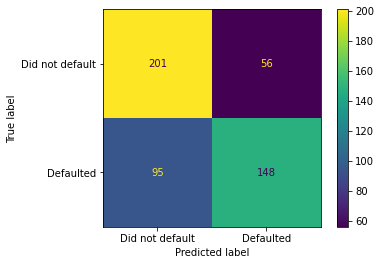

In [41]:
plot_confusion_matrix(clf_svm, 
                     X_test_scaled, 
                     y_test,
                     values_format='d',
                     display_labels=["Did not default", "Defaulted"])
plt.show()

The performance is not great. Only around 78% and 61% of labels were correctly classified as **"Did not default"** and **"Defaulted"**, respectively. Now, we will use cross validation to optimise the parameters.

## 7. Optimization - Cross Validation and GridSearchCV

Optimizing a SVM is to find the best values for gamma, and probably a regulation parameter 

In [43]:
param_grid = [
    {'C': [0.5, 1, 10, 100],                      # Regularization parameters
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']},
]
optimal_params = GridSearchCV(SVC(),
                             param_grid,
                             cv=5, 
                             scoring='accuracy')
optimal_params.fit(X_train_scaled, y_train)
print(optimal_params.best_params_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}


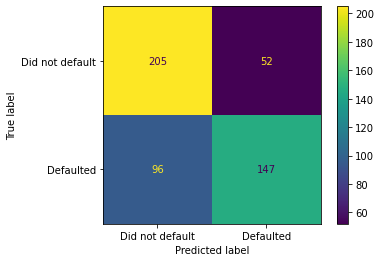

In [45]:
plot_confusion_matrix(optimal_params,
                     X_test_scaled,
                     y_test,
                     values_format='d',
                     display_labels=["Did not default", "Defaulted"])
plt.show()

The optimization did not help that much, the accuracy is similar. 

We will use PCA to visualise the decision boundaries

In [46]:
pca = PCA() ## By default, PCA() centers the data, but does not scale it
X_train_pca = pca.fit_transform(X_train_scaled)

per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)  ## Percentage variance explained by principle component

array([11.3,  6.4,  6.2,  5.9,  5.2,  4.8,  4.4,  3.6,  3.1,  2.7,  2.6,
        2.4,  2.2,  2. ,  1.9,  1.8,  1.6,  1.5,  1.5,  1.4,  1.4,  1.4,
        1.3,  1.3,  1.3,  1.3,  1.2,  1.1,  1.1,  1.1,  1. ,  1. ,  0.9,
        0.9,  0.9,  0.8,  0.8,  0.8,  0.7,  0.7,  0.7,  0.6,  0.6,  0.5,
        0.5,  0.4,  0.4,  0.4,  0.3,  0.3,  0.3,  0.3,  0.3,  0.2,  0.2,
        0.2,  0.1,  0.1,  0.1,  0.1,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,  0. ,
        0. ,  0. ,  0. ,  0. ])

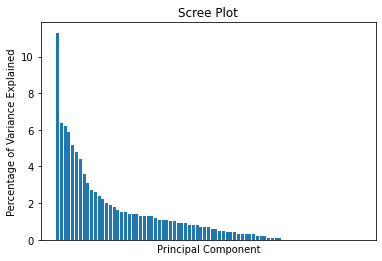

In [61]:
labels = [str(x) for x in range(1, len(per_var)+1)]
plt.bar(x = range(1, len(per_var)+1), height=per_var)
plt.tick_params(axis = 'x',
               which='both',
               bottom=False,
               top=False,
               labelbottom=False)
plt.ylabel("Percentage of Variance Explained")
plt.xlabel("Principal Component")
plt.title("Scree Plot")
plt.show()